# Bite Size Bayes

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## The Euro problem

In [a previous notebook](https://colab.research.google.com/github/AllenDowney/BiteSizeBayes/blob/master/07_euro.ipynb) I presented a problem from David MacKay's book, [*Information Theory, Inference, and Learning Algorithms*](http://www.inference.org.uk/mackay/itila/p0.html):

> A statistical statement appeared in The Guardian on
Friday January 4, 2002:
>
> >"When spun on edge 250 times, a Belgian one-euro coin came
up heads 140 times and tails 110. ‘It looks very suspicious
to me’, said Barry Blight, a statistics lecturer at the London
School of Economics. ‘If the coin were unbiased the chance of
getting a result as extreme as that would be less than 7%’."
>
> But [asks MacKay] do these data give evidence that the coin is biased rather than fair?

To answer this question, we made these modeling decisions:

* If you spin a coin on edge, there is some probability, $x$, that it will land heads up.

* The value of $x$ varies from one coin to the next, depending on how the coin is balanced and other factors.

We started with a uniform prior distribution for $x$, then updated it 250 times, once for each spin of the coin.  Then we used the posterior distribution to compute the MAP, posterior mean, and a credible interval.

But we never really answered MacKay's question.

In this notebook, I introduce the binomial distribution and we will use it to solve the Euro problem more efficiently.  Then we'll get back to MacKay's question and see if we can find a more satisfying answer.

## Binomial distribution

Suppose I tell you that a coin is "fair", that is, the probability of heads is 50%.  If you spin it twice, there are four outcomes: `HH`, `HT`, `TH`, and `TT`.

All four outcomes have the same probability, 25%.  If we add up the total number of heads, it is either 0, 1, or 2.  The probability of 0 and 2 is 25%, and the probability of 1 is 50%.

More generally, suppose the probability of heads is `p` and we spin the coin `n` times.  What is the probability that we get a total of `k` heads?

The answer is given by the binomial distribution:

$P(k; n, p) = \binom{n}{k} p^k (1-p)^{n-k}$

where $\binom{n}{k}$ is the [binomial coefficient](https://en.wikipedia.org/wiki/Binomial_coefficient), usually pronounced "n choose k".

We can compute this expression ourselves, but we can also use the SciPy function `binom.pmf`:

In [2]:
from scipy.stats import binom

n = 2
p = 0.5
ks = np.arange(n+1)

a = binom.pmf(ks, n, p)
a

array([0.25, 0.5 , 0.25])

If we put this result in a Series, the result is the distribution of `k` for the given values of `n` and `p`.

In [3]:
pmf_k = pd.Series(a, index=ks)
pmf_k

0    0.25
1    0.50
2    0.25
dtype: float64

The following function computes the binomial distribution for given values of `n` and `p`:

In [4]:
def make_binomial(n, p):
    """Make a binomial PMF.
    
    n: number of spins
    p: probability of heads
    
    returns: Series representing a PMF
    """
    ks = np.arange(n+1)

    a = binom.pmf(ks, n, p)
    pmf_k = pd.Series(a, index=ks)
    return pmf_k

And here's what it looks like with `n=250` and `p=0.5`:

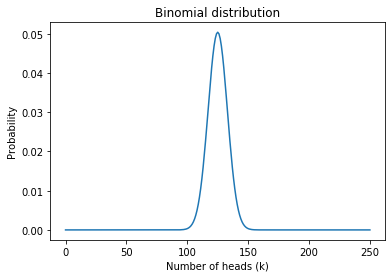

In [5]:
pmf_k = make_binomial(n=250, p=0.5)
pmf_k.plot()

plt.xlabel('Number of heads (k)')
plt.ylabel('Probability')
plt.title('Binomial distribution');

The most likely value in this distribution is 125:

In [6]:
pmf_k.idxmax()

125

But even though it is the most likely value, the probability that we get exactly 125 heads is only about 5%.

In [7]:
pmf_k[125]

0.05041221314731537

In MacKay's example, we got 140 heads, which is less likely than 125:

In [8]:
pmf_k[140]

0.008357181724917673

In the article MacKay quotes, the statistician says, ‘If the coin were unbiased the chance of getting a result as extreme as that would be less than 7%’.

We can use the binomial distribution to check his math.  The following function takes a PMF and computes the total probability of values greater than or equal to `threshold`. 

In [9]:
def prob_ge(pmf, threshold):
    """Probability of values greater than a threshold.
    
    pmf: Series representing a PMF
    threshold: value to compare to
    
    returns: probability
    """
    ge = (pmf.index >= threshold)
    total = pmf[ge].sum()
    return total

Here's the probability of getting 140 heads or more:

In [10]:
prob_ge(pmf_k, 140)

0.033210575620022706

It's about 3.3%, which is less than 7%.  The reason is that the statistician includes all values "as extreme as" 140, which includes values less than or equal to 110, because 140 exceeds the expected value by 15 and 110 falls short by 15.

The probability of values less than or equal to 110 is also 3.3%,
so the total probability of values "as extreme" as 140 is about 7%.

The point of this calculation is that these extreme values are unlikely if the coin is fair.

That's interesting, but it doesn't answer MacKay's question.  Let's see if we can.

## Estimating x

As promised, we can use the binomial distribution to solve the Euro problem more efficiently.  Let's start again with a uniform prior:

In [11]:
xs = np.arange(101) / 100
uniform = pd.Series(1, index=xs)
uniform /= uniform.sum()

We can use `binom.pmf` to compute the likelihood of the data for each possible value of $x$.

In [12]:
k = 140
n = 250
xs = uniform.index

likelihood = binom.pmf(k, n, p=xs)

Now we can do the Bayesian update in the usual way, multiplying the priors and likelihoods,

In [13]:
posterior = uniform * likelihood

Computing the total probability of the data,

In [14]:
total = posterior.sum()
total

0.003944617569326327

And normalizing the posterior,

In [15]:
posterior /= total

Here's what it looks like.

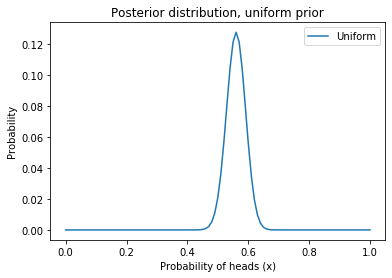

In [16]:
posterior.plot(label='Uniform')

plt.xlabel('Probability of heads (x)')
plt.ylabel('Probability')
plt.title('Posterior distribution, uniform prior')
plt.legend()

**Exercise:** Based on what we know about coins in the real world, it doesn't seem like every value of $x$ is equally likely.  I would expect values near 50% to be more likely and values near the extremes to be less likely.  

In Notebook 7, we used a triangle prior to represent this belief about the distribution of $x$.  The following code makes a PMF that represents a triangle prior.

In [17]:
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)

a = np.append(ramp_up, ramp_down)

triangle = pd.Series(a, index=xs)
triangle /= triangle.sum()

Update this prior with the likelihoods we just computed and plot the results.  

In [18]:
# Solution

posterior2 = triangle * likelihood
total2 = posterior2.sum()
total2

0.007008842590058512

In [19]:
# Solution

posterior2 /= total2

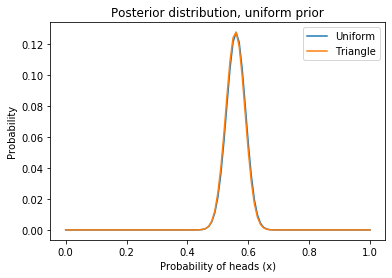

In [20]:
# Solution

posterior.plot(label='Uniform')
posterior2.plot(label='Triangle')

plt.xlabel('Probability of heads (x)')
plt.ylabel('Probability')
plt.title('Posterior distribution, uniform prior')
plt.legend();

## Evidence

Finally, let's get back to MacKay's question: do these data give evidence that the coin is biased rather than fair?

I'll use a Bayes table to answer this question, so here's the function that makes one:

In [21]:
def make_bayes_table(hypos, prior, likelihood):
    """Make a Bayes table.
    
    hypos: sequence of hypotheses
    prior: prior probabilities
    likelihood: sequence of likelihoods
    
    returns: DataFrame
    """
    table = pd.DataFrame(index=hypos)
    table['prior'] = prior
    table['likelihood'] = likelihood
    table['unnorm'] = table['prior'] * table['likelihood']
    prob_data = table['unnorm'].sum()
    table['posterior'] = table['unnorm'] / prob_data
    return table

Recall that data, $D$, is considered evidence in favor of a hypothesis, `H`, if the posterior probability is greater than the prior, that is, if

$P(H|D) > P(H)$

For this example, I'll call the hypotheses `fair` and `biased`:

In [22]:
hypos = ['fair', 'biased']

And just to get started, I'll assume that the prior probabilities are 50/50.

In [23]:
prior = [0.5, 0.5]

Now we have to compute the probability of the data under each hypothesis.

If the coin is fair, the probability of heads is 50%, and we can compute the probability of the data (140 heads out of 250 spins) using the binomial distribution:

In [24]:
k = 140
n = 250

like_fair = binom.pmf(k, n, p=0.5)
like_fair

0.008357181724917673

So that's the probability of the data, given that the coin is fair.

But if the coin is biased, what's the probability of the data?  Well, that depends on what "biased" means.

If we know ahead of time that "biased" means the probability of heads is 56%, we can use the binomial distribution again:

In [25]:
like_biased = binom.pmf(k, n, p=0.56)
like_biased

0.05077815959517949

Now we can put the likelihoods in the Bayes table:

In [26]:
likes = [like_fair, like_biased]

make_bayes_table(hypos, prior, likes)

,prior,likelihood,unnorm,posterior
fair,0.5,0.008357,0.004179,0.141323
biased,0.5,0.050778,0.025389,0.858677


The posterior probability of `biased` is about 86%, so the data is evidence that the coin is biased, at least for this definition of "biased".

But we used the data to define the hypothesis, which seems like cheating.  To be fair, we should define "biased" before we see the data.

## Uniformly distributed bias

Suppose "biased" means that the probability of heads is anything except 50%, and all other values are equally likely.

We can represent that definition by making a uniform distribution and removing 50%.

In [27]:
biased_uniform = uniform.copy()
biased_uniform[50] = 0
biased_uniform /= biased_uniform.sum()

Now, to compute the probability of the data under this hypothesis, we compute the probability of the data for each value of $x$.

In [28]:
xs = biased_uniform.index
likelihood = binom.pmf(k, n, xs)

And then compute the total probability in the usual way:

In [29]:
like_uniform = np.sum(biased_uniform * likelihood)
like_uniform

0.0039004919277704133

So that's the probability of the data under the "biased uniform" hypothesis.

Now we make a Bayes table that compares the hypotheses `fair` and `biased uniform`:

In [30]:
hypos = ['fair', 'biased uniform']
likes = [like_fair, like_uniform]

make_bayes_table(hypos, prior, likes)

,prior,likelihood,unnorm,posterior
fair,0.5,0.008357,0.004179,0.681792
biased uniform,0.5,0.003900,0.001950,0.318208


Using this definition of `biased`, the posterior is less than the prior, so the data are evidence that the coin is *fair*.

In this example, the data might support the fair hypothesis or the biased hypothesis, depending on the definition of "biased".

**Exercise:** Suppose "biased" doesn't mean every value of $x$ is equally likely.  Maybe values near 50% are more likely and values near the extremes are less likely.  In the previous exercise we created a PMF that represents a triangle-shaped distribution.

We can use it to represent an alternative definition of "biased":

In [31]:
biased_triangle = triangle.copy()
biased_triangle[50] = 0
biased_triangle /= biased_triangle.sum()

Compute the total probability of the data under this definition of "biased" and use a Bayes table to compare it with the fair hypothesis.

Is the data evidence that the coin is biased?

In [32]:
# Solution

like_triangle = np.sum(biased_triangle * likelihood)
like_triangle

0.006981325464857304

In [33]:
# Solution

hypos = ['fair', 'biased triangle']
likes = [like_fair, like_triangle]

make_bayes_table(hypos, prior, likes)

,prior,likelihood,unnorm,posterior
fair,0.5,0.008357,0.004179,0.54485
biased triangle,0.5,0.006981,0.003491,0.45515


In [34]:
# Solution

# For this definition of "biased", 
# the data are slightly in favor of the fair hypothesis.

## Bayes factor

In the previous section, we used a Bayes table to see whether the data are in favor of the fair or biased hypothesis.

I assumed that the prior probabilities were 50/50, but that was an arbitrary choice.  

And it was unnecessary, because we don't really need a Bayes table to say whether the data favor one hypothesis or another: we can just look at the likelihoods.

Under the first definition of biased, `x=0.56`, the likelihood of the biased hypothesis is higher: 

In [35]:
like_fair, like_biased

(0.008357181724917673, 0.05077815959517949)

Under the biased uniform definition, the likelihood of the fair hypothesis is higher.

In [36]:
like_fair, like_uniform

(0.008357181724917673, 0.0039004919277704133)

The ratio of these likelihoods tells us which hypothesis the data support.

If the ratio is less than 1, the data support the second hypothesis:

In [37]:
like_fair / like_biased

0.16458220998050985

If the ratio is greater than 1, the data support the first hypothesis:

In [38]:
like_fair / like_uniform

2.142596851801403

This likelihood ratio is called a [Bayes factor](https://en.wikipedia.org/wiki/Bayes_factor); it provides a concise way to present the strength of a dataset as evidence for or against a hypothesis.

## Summary

In this notebook I introduced the binomial disrtribution and used it to solve the Euro problem more efficiently.

Then we used the results to (finally) answer the original version of the Euro problem, considering whether the data support the hypothesis that the coin is fair or biased.  We found that the answer depends on how we define "biased".  And we summarized the results using a Bayes factor, which quantifies the strength of the evidence.

[In the next notebook](https://colab.research.google.com/github/AllenDowney/BiteSizeBayes/blob/master/13_price.ipynb) we'll start on a new problem based on the television game show *The Price Is Right*.

## Exercises

**Exercise:** In preparation for an alien invasion, the Earth Defense League has been working on new missiles to shoot down space invaders.  Of course, some missile designs are better than others; let's assume that each design has some probability of hitting an alien ship, `x`.

Based on previous tests, the distribution of `x` in the population of designs is roughly uniform between 10% and 40%.

Now suppose the new ultra-secret Alien Blaster 9000 is being tested.  In a press conference, a Defense League general reports that the new design has been tested twice, taking two shots during each test.  The results of the test are confidential, so the general won't say how many targets were hit, but they report: "The same number of targets were hit in the two tests, so we have reason to think this new design is consistent."

Is this data good or bad; that is, does it increase or decrease your estimate of `x` for the Alien Blaster 9000?

Plot the prior and posterior distributions, and use the following function to compute the prior and posterior means.

In [39]:
def pmf_mean(pmf):
    """Compute the mean of a PMF.
    
    pmf: Series representing a PMF
    
    return: float
    """
    return np.sum(pmf.index * pmf)

In [40]:
# Solution

xs = np.linspace(0.1, 0.4)
prior = pd.Series(1, index=xs)
prior /= prior.sum()

In [41]:
# Solution

likelihood = xs**2 + (1-xs)**2

In [42]:
# Solution

posterior = prior * likelihood
posterior /= posterior.sum()

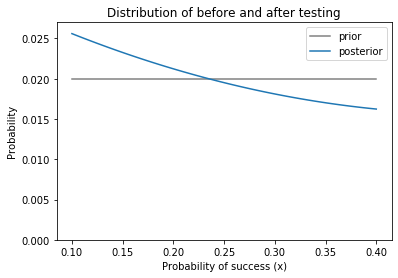

In [43]:
# Solution

prior.plot(color='gray', label='prior')
posterior.plot(label='posterior')

plt.xlabel('Probability of success (x)')
plt.ylabel('Probability')
plt.ylim(0, 0.027)
plt.title('Distribution of before and after testing')
plt.legend();

In [44]:
# Solution

pmf_mean(prior), pmf_mean(posterior)

(0.25, 0.2378145906339599)

In [45]:
# With this prior, being "consistent" is more likely
# to mean "consistently bad".